In [5]:
import sys
sys.path.append('../src')

from module.module import Linear
from module.activation import TanH, Sigmoide

from loss.loss import BCELoss
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.generation import generate_linear_data, generate_data_gauss
from utils.plots import plot_net
from utils.evaluation import accuracy

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [6]:
data = pkl.load(open("../data/usps.pkl",'rb')) 

In [7]:
X_train = data["X_train"]
y_train = data["Y_train"]

X_test = data["X_test"]
y_test = data["Y_test"]

In [40]:
input_neurons = X_train.shape[1]
hidden_neurons = 100
output_neurons = 10

encoder = [
    Linear(input_neurons, hidden_neurons, bias=True),
    TanH(),
    Linear(hidden_neurons, output_neurons, bias=True),
    TanH()
]

decoder = [
    Linear(output_neurons, hidden_neurons, bias=True),
    TanH(),
    Linear(hidden_neurons, input_neurons, bias=True),
    Sigmoide()
]

net = Sequentiel([*encoder, *decoder])

optim = Optim(net, BCELoss(), eps=1e-5)
optim.SGD(X_train, X_train, batch_size=len(X_train), epochs=1000, verbose=False)

plot_net(X_train, y_train, net, optim.train_loss, net_type="auto_encodeur")
# print("Accuracy :", accuracy(net, X_train, y_train, multi_class=True))

100%|██████████| 1000/1000 [04:54<00:00,  3.39it/s]

Training completed.


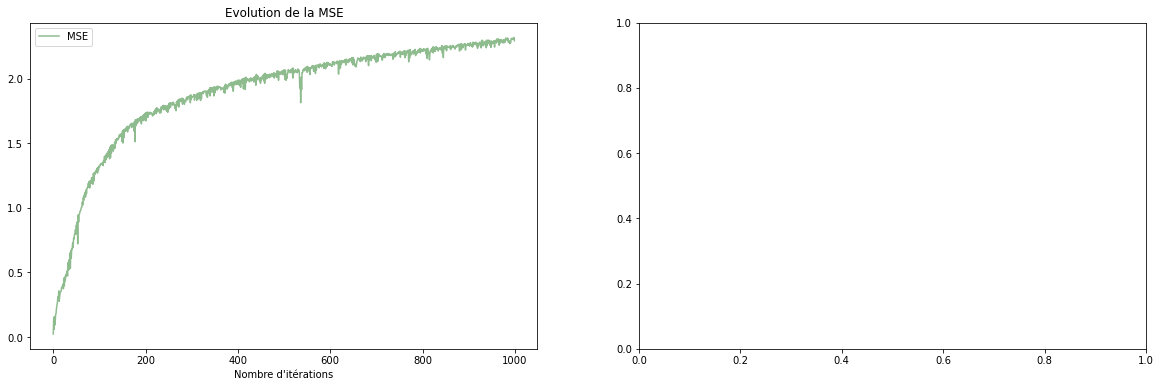

In [46]:
plot_net(X_train, y_train, net, optim.train_loss, net_type="auto_encodeur")

In [41]:
X_hat = net(X_train)

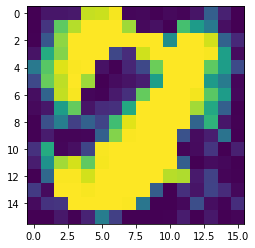

In [42]:
plt.imshow(X_hat[10].reshape((16, 16)))

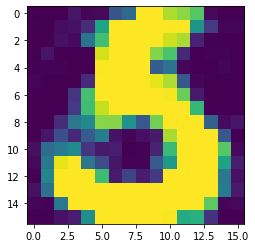

In [44]:
plt.imshow(X_hat[11].reshape((16, 16)))

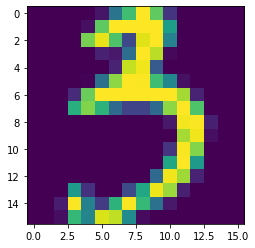

In [45]:
plt.imshow(X_train[11].reshape((16, 16)))

In [9]:
input_neurons = X_train.shape[1]
h1 = 128
h2 = 64
h3 = 32
h4 = 16

encoder = [
    Linear(input_neurons, h1, bias=True),
    TanH(),
    Linear(h1, h2, bias=True),
    TanH(),
    Linear(h2, h3, bias=True),
    TanH(),
    Linear(h3, h4, bias=True),
    TanH()
]

decoder = [
    Linear(h4, h3, bias=True),
    TanH(),
    Linear(h3, h2, bias=True),
    TanH(),
    Linear(h2, h1, bias=True),
    TanH(),
    Linear(h1, input_neurons, bias=True),
    Sigmoide()
]

net = Sequentiel([*encoder, *decoder])

optim = Optim(net, BCELoss(), eps=1e-5)
optim.SGD(X_train, X_train, batch_size=len(X_train), epochs=100, verbose=False)

# plot_net(X_train, y_train, net, optim.train_loss, net_type="auto_encodeur")
# print("Accuracy :", accuracy(net, X_train, y_train, multi_class=True))

100%|██████████| 100/100 [00:37<00:00,  2.68it/s]

Training completed.


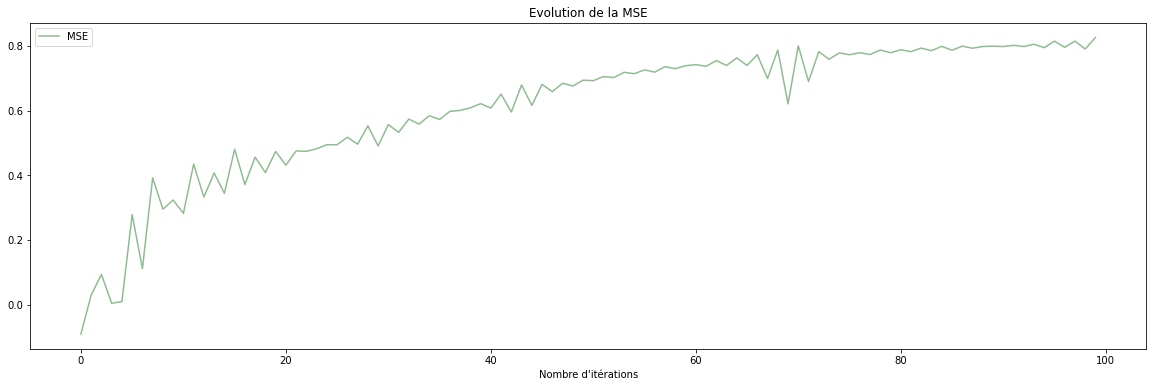

In [10]:
plot_net(X_train, y_train, net, optim.train_loss, net_type="auto_encodeur")

In [13]:
Xhat = net(X_train)

In [11]:
def plot_usps_predictions(X, Xhat, i):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    axs[0].imshow(X[i].reshape((16, 16)))
    axs[0].set_title('Image originale')
    axs[1].imshow(Xhat[i].reshape((16, 16)))
    axs[1].set_title('Image reconstruite')
    plt.show()

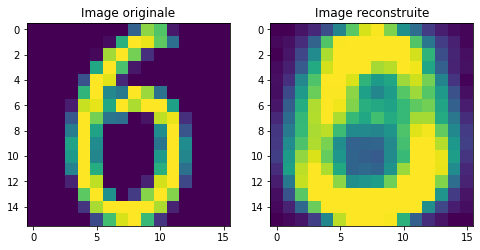

In [19]:
plot_usps_predictions(X_train, Xhat, 60)